### Assignment 06 (50 pts) - Memory and Decision Making - Due November 13th, 11:59PM

***

(5 pts) Be sure that your code is well-documented for reproducibility. Set a random seed at the top of your code for reproducibility (`np.random.seed(seed_number)`). Every function should have a docstring (simple functions can be short, longer functions should contain more detail). Before submitting, re-run your code. Figures should be labeled (axes labels, legends, etc), and clearly address any questions asked below! Remember, the whole goal is to have clear and concise communication of what you are finding computationally. 

In [122]:
# I only used these modules, but feel free to add your own
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(1337)

***
### (20 pts) Question 1 - Spatial Working Memory (Bump Attractor Model)
Simulate a 1D line network that stores a stimulus location as a bump of persistenct activity.

**Model:**
$$
\tau \frac{d r_i}{d t} = -r_i + f\bigg(\sum_j W_{ij} r_j + I_i\bigg)
$$

where $W_{ij}$ implements **local excitation** and **global inhibition**:

$$
W_{ij} = A \exp\bigg[-\frac{(x_i-x_j)^2}{2\sigma^2}\bigg] -\kappa 
$$

Use $N=40$ neurons evenly spaced between and at locations $x_i \in[-1,1]$ with the parameters $\tau= 10$, $ A = 1.2$, $\sigma =0.1$, $\kappa = 0.5$, $dt=1$, $T=1000$, and:

$$
f(x) = \frac{1}{1+e^{-2(x-0.1)}}
$$

Apply an external stimulus $I_i = 1$ for 200 ms to the neurons bewteen $0.3 < x_i < 0.8$.

For this model:

1. (5 pts) Plot the **weight matrix** $W_{ij}$ to visualize local excitation and broad inhibition. Use a heatmap with Gaussian interpolation (e.g. `matplotlib`'s `imshow` or `seaborn`'s `heatmap`). Be sure to include a colorbar and set the colormap to `coolwarm`. You should see a very red diagonal. 
2. (5 pts) Simulate network activity before the stimulus period, during the stimulus period (200-400 ms) and during the delay period (400 - 1000 ms). Use Forward Euler to simulate the network. For each neuron, you have to compute the argument to the sigmoid: $\sum_j W_{ij} r_j + I_i$, however if $W$ is the weight matrix, $r$ is a $N$ array, and $I$ is a $N$ array for the current time step then you can compute $\sum_j W_{ij} r_j + I_i$ as `W @ r + I`.
3. (5 pts) Plot a heatmap of the network activity where the neuron ($x$ location) is on the horizontal axis and time is on the vertical axis. The colors should correspond to the firing rate of each neuron. Repeat this for the external stimulus in a second plot. 
4. (5 pts) At values of $t=100,300,600$, plot the firing rate of all neurons as a function of location ($x$).

In [123]:
# parameters
tau = 10
A = 1.2
sigma = 0.1
kappa = 0.5
dt = 1
T = 1000
N = 40

neuron_locs = np.linspace(-1,1,N)
def f(x):
    return 1 / (1 + np.exp((-2)*(x-0.1)))

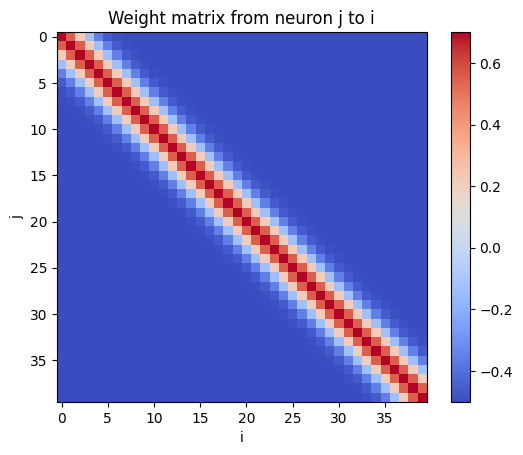

In [124]:
# 1. create and plot the weight matrix

W = np.zeros((len(neuron_locs),len(neuron_locs)))
for i in range(N):
    for j in range(N):
        W[i,j] = A * np.exp(-((neuron_locs[i]-neuron_locs[j])**2)/(2*sigma**2)) - kappa

plt.imshow(W, cmap='coolwarm');
plt.colorbar();
plt.xlabel("i");
plt.ylabel("j");
plt.title("Weight matrix from neuron j to i");

In [125]:
# 2. Simulate network activity
rates = np.zeros((T,len(neuron_locs)))
Is = np.zeros((T,len(neuron_locs)))
for t in range(1,T):
    if t < 200 or t > 400:
        I = np.zeros(len(neuron_locs))
    else:
        I = ((neuron_locs > 0.3) & (neuron_locs < 0.8)).astype(float)
    Is[t] = I
    rates[t] = rates[t-1] + (-rates[t-1] + f(W @ rates[t-1] + I)) / tau

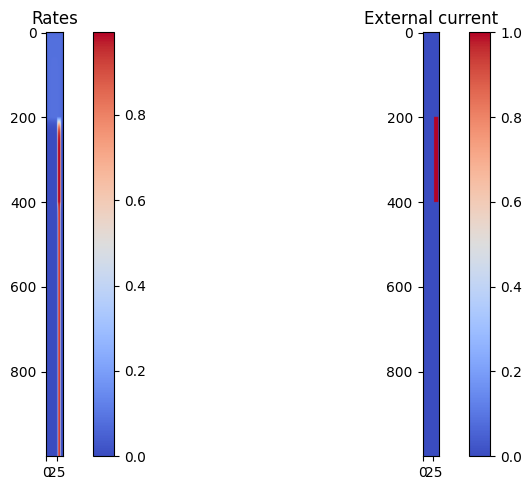

In [126]:
# 3. plot rates and external current
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

im1 = axs[0].imshow(rates, cmap='coolwarm')
axs[0].set_title('Rates')
fig.colorbar(im1, ax=axs[0]);

im2 = axs[1].imshow(Is, cmap='coolwarm')
fig.colorbar(im2, ax=axs[1]);
axs[1].set_title('External current')
plt.tight_layout()
plt.show()

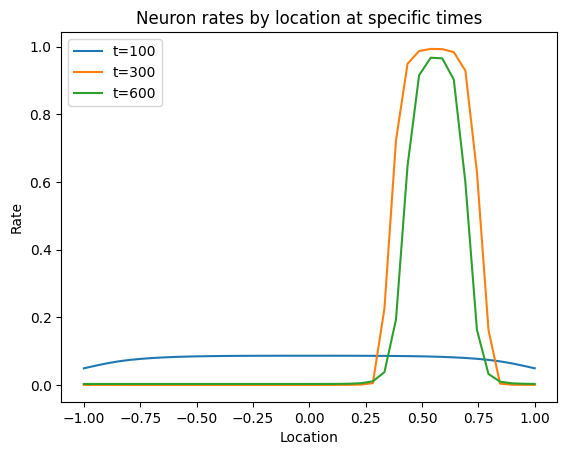

In [127]:
# 4. Plotting firing rate of all neurons as a function of location
ts = [100,300,600]
for t in ts:
    plt.plot(neuron_locs, rates[t], label=f't={t}')

plt.legend();
plt.title("Neuron rates by location at specific times");
plt.xlabel("Location");
plt.ylabel("Rate");

***
### (25 pts) Question 2: Decision Making as Evidence Accumulation

Implement and analyze the **drift-diffusion model (DDM)** as a reduced description of decision dynamics.

**Model**:
$$
dx=\mu dt + \sigma dW_t
$$

- $x(t)$ is the decision variable (evidecne accumulator)
- $\mu$ is the drift rate (stimulus bias).
- $\sigma$ is the noise amplitude.
- $dW_t$ is a Guassian white noise (use `np.random.normal(0,sqrt(dt))`).

A decision is made when $x(t)$ hits either $\pm 1$ thresholds.

Use the parameteres $dt = 0.001$, $x_0 = 0$, $\sigma = 0.3$.

(5 pts) For the drift values of $\mu = $`np.arange(0,1,0.01)` simulate 200 trials per condition (this may take some time to simulate, 1.5 minutes on my machine). 

When $\mu = 0,0.1,0.2$:
- (5 pts) Plot 30 example trajectories. Set positive decisions as blue, negative decisions as red, and failed decisions as gray.
- (5 pts) Compute the positive accuracy (fraction ending at +1) and **mean reaction time (RT)** as the average threshold-crossing timeinclude this on your plots.
- (5 pts) Plot the histograms of positive reaction times and negative reaction time

(5 pts) Then for all drift values, plot the accuracy of positive decisions (horizontal axis) vs **$RT_+$** (vertical axis) as a scatter plot, where the $\mu$ values are color-coded by the `coolwarm` colormap. 


In [128]:
def dx(mu, dt=0.001, sigma=0.3):
    """
    Returns the SDE value for the drift diffusion model.
    Noise term is proportional to sqrt(dt)

    Parameters
    -----------
    mu : float
        drift rate or bias strength
    dt : float
        (optional) time step
    sigma : float
        (optional) diffusion or noise magnitude

    Returns
    -------
    float
        value of drift diffusion model
    """
    dw = np.sqrt(dt)*np.random.randn()
    return mu*dt + sigma*dw


def ddm_trial(mu, x0=0, dt=0.001, sigma=0.3, boundary=1, t_max=5):
    """
    Simulates one decision trajectory of DDM and one trial results in:
        Result of trajectory as either +/- boundary or a 0 for no success
        Amount of time to reach the result
        Trajectory of path to that result

    Parameters
    -----------
    mu : float
        drift rate or bias strength
    x0 : float
        (optional) initial bias to decision
    dt : float
        (optional) time step
    sigma : float
        (optional) diffusion or noise magnitude
    boundary : float
        (optional) +/- value of boundary decision
    t_max : float
        (optional) max time allowed to decide

    Returns
    -------
    float
        result of trajectory (+/- boundary or 0 for no success)
    float
        decision time of trajectory
    np.ndarray
        trajectory of decision variable x
    """
    steps = int(t_max / dt)
    x = np.zeros(steps)
    x[0] = x0
    for i in range(1, steps):
        x[i] = x[i-1] + dx(mu, dt, sigma)
        if x[i] >= boundary:
          return 1, i*dt, x[0:i]
        elif x[i] <= -boundary:
          return -1, i*dt, x[0:i]
    return 0, t_max, x

In [129]:
# 1. simulate 200 trials per value of mu
mus = np.arange(0,1,0.01)
N = 200

# store positive accuracies and positive reaction times for each trial
posaccs = []
reactps = []

for i in range(mus.shape[0]):
    # avoid divide by zero error
    poscount = 0.00001
    negcount = 0.00001
    reactp = 0
    reactn = 0

    for j in range(N):
        res, dec, traj = ddm_trial(mus[i])
        if res == 1:
            poscount += 1
            reactp += dec
        elif res == -1:
            negcount += 1
            reactn += dec
        
    posaccs.append(poscount / N)
    reactps.append(reactp/poscount)

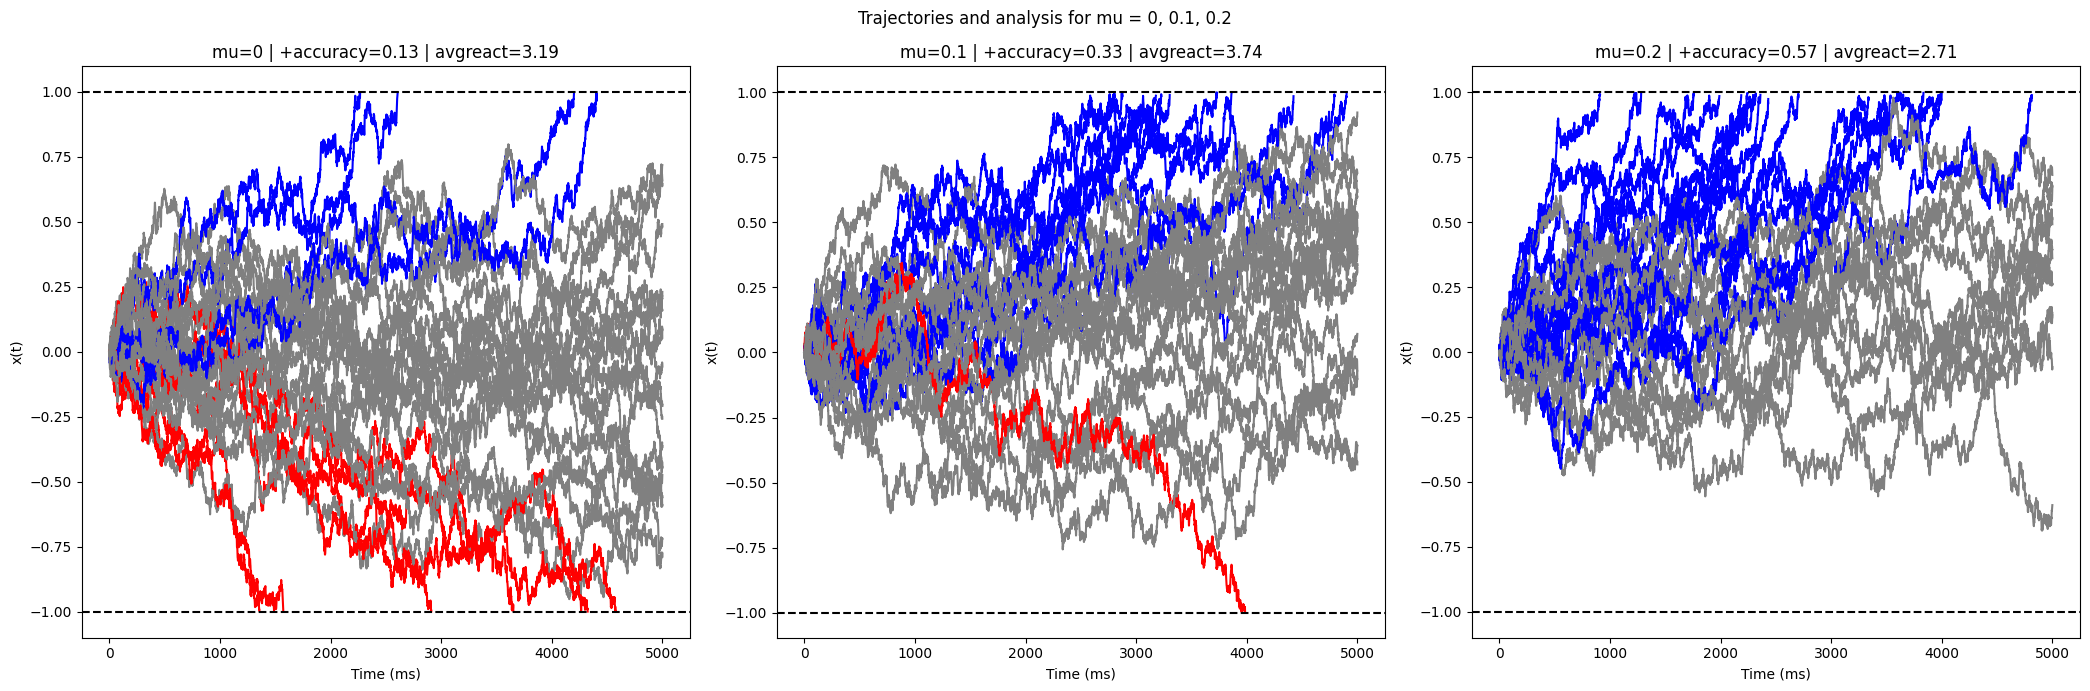

In [130]:
# 2-3. Plotting 30 example trajectories for mu = 0, 0.1, 0.2
N = 30
ms = [0, 0.1, 0.2]
fig, axs = plt.subplots(1,3,figsize=(21,7))
totalpostimes = []
totalnegtimes = []

for m in range(len(ms)):
    # avoid divide by zero error
    poscount = 0.00001
    negcount = 0.00001
    reactp = 0
    reactn = 0
    postimes = []
    negtimes = []

    for i in range(N):
        res, dec, traj = ddm_trial(ms[m])
        if res == 1:
            axs[m].plot(traj, color="blue")
            poscount += 1
            reactp += dec
            postimes.append(dec)
        elif res == -1:
            axs[m].plot(traj, color="red")
            negcount += 1
            reactn += dec
            negtimes.append(dec)
        else:
            axs[m].plot(traj, color="gray")
    axs[m].axhline(1, color="k", ls="--", lw=1.5, zorder=15)
    axs[m].axhline(-1, color="k", ls="--", lw=1.5, zorder=15)
    axs[m].set_xlabel("Time (ms)")
    axs[m].set_ylabel("x(t)")
    axs[m].set_title(f"mu={ms[m]} | +accuracy={poscount/N:.2f} | avgreact={(reactp+reactn)/(poscount+negcount):.2f}")

    totalpostimes.extend(postimes)
    totalnegtimes.extend(negtimes)

fig.suptitle("Trajectories and analysis for mu = 0, 0.1, 0.2")
plt.tight_layout()
plt.show()

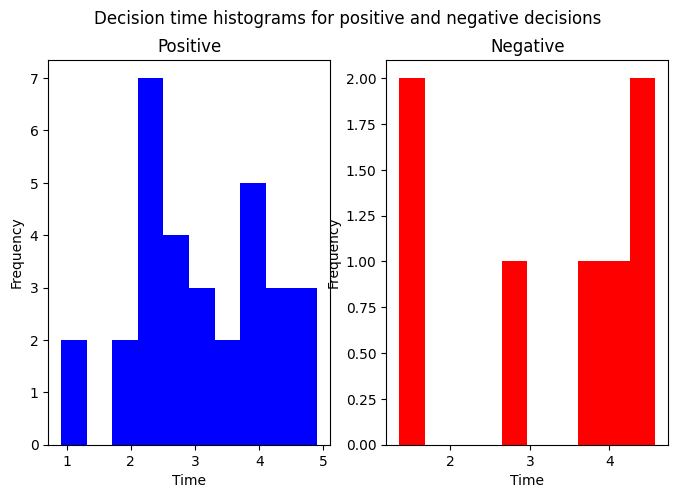

In [131]:
# 4. Plotting histograms of positive reaction times and negative reaction time
fig, axs = plt.subplots(1,2, figsize=(8,5))
axs[0].hist(totalpostimes, color="blue")
axs[1].hist(totalnegtimes, color="red")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Frequency")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Negative")
axs[0].set_title("Positive")
fig.suptitle("Decision time histograms for positive and negative decisions");

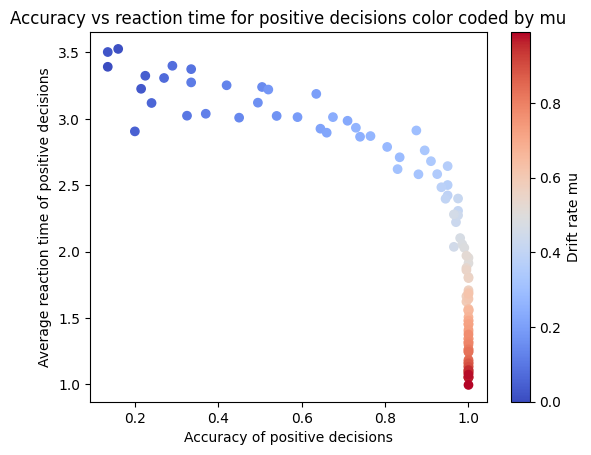

In [132]:
# 5. Plotting positive accuracy vs positive reaction time for all drift values
scatter = plt.scatter(posaccs, reactps, c=mus, cmap="coolwarm")
plt.colorbar(scatter, label='Drift rate mu')
plt.xlabel("Accuracy of positive decisions")
plt.ylabel("Average reaction time of positive decisions")
plt.title("Accuracy vs reaction time for positive decisions color coded by mu");